In [8]:
# get_ipython().magic('matplotlib notebook')
# get_ipython().magic('matplotlib inline')
# get_ipython().magic('load_ext autoreload')
# get_ipython().magic('autoreload 2')
%matplotlib inline
%load_ext autoreload
%autoreload 2
    
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import shapefile as shp
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# from dask.distributed import Client
# from dask.diagnostics import ProgressBar
# import dask

# n_workers=36
# tot_mem  = 100 # GB
# print(' --> memory_limit: {:3.3f} GB'.format(tot_mem/(n_workers+1)))
# dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
# client = Client(n_workers=n_workers, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(tot_mem/n_workers))
# client

In [10]:
# Parameters
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
save_path = None #'~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
which_cycl= None #5 # set None --> take path as in input_paths otherwise add dir of cycle
which_mode= 'zmeantransects'

#_____________________________________________________________________________________
input_paths= list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')

input_names= list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

vname     = 'temp'
year      = [1979,2019]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/' # None #
ref_name  = None #'TKE, ck=0.1' # None
ref_year  = None #[1979,2019]
ref_mon, ref_day, ref_record = None, None, None
ref_cstr, ref_cnum = 'blue2red', 20
ref_cref, ref_crange, ref_cmin, ref_cmax, ref_cfac, ref_climit = None, None, None, None, None, None
ref_chist, ref_ctresh = True, 0.995
ref_rescale = None

#_____________________________________________________________________________________
box_region = list()
box_region.append('global')
# box_region.append('ocean_basins/Arctic_Basin.shp')
#box_region.append('ocean_basins/Eurasian_Basin.shp')
#box_region.append('ocean_basins/Atlantic_Basin.shp')
#box_region.append('mpas_region/Canada_Basin.shp')
#box_region.append('mpas_region/North_Atlantic_Ocean.shp')
#box_region.append('mpas_region/Greenland_Sea.shp')
#box_region.append('mpas_region/Irminger_Sea.shp')
#box_region.append('mpas_region/Norwegian_Sea.shp')
#box_region.append('mpas_region/Labrador_Sea.shp')
#box_region.append('mpas_region/North_Pacific_Ocean.shp')
#box_region.append('mpas_region/South_Pacific_Ocean.shp')
#box_region.append('mpas_region/Southern_Ocean.shp')
#box_region.append('mpas_region/Western_Weddell_Sea.shp')

#_____________________________________________________________________________________
do_clim   = True
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'

#_____________________________________________________________________________________
cstr      = 'blue2red'
cnum      = 20
cref      = None
crange, cmin, cmax, cfac, climit = None, None, None, None, None
chist, ctresh = True, 0.995

#_____________________________________________________________________________________
ncolumn   = 2
do_rescale= None
which_dpi = 300
do_contour= True
do_ylog   = False
do_reffig = True
figfac    = [8, 3.5] #[7, 3.5]


In [11]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
if (which_cycl is not None) and (which_cycl != "None"): 
    for ii,ipath in enumerate(input_paths):
        # print(ii, ipath, ipath[0])
        input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
        print(ii, input_paths[ii])
    
    if (ref_path is not None) and (ref_path != "None"): 
        ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
        print('R', ref_path)
        
#______________________________________________________________________________________________________        
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path is not None) and (ref_path != "None"): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record    
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)    
    ref_cinfo['cref']=0.0 
else:
    do_reffig=False

#______________________________________________________________________________________________________    
# concatenate list = list1+list2
if (ref_path is not None) and (ref_path != "None"): 
    if isinstance(ref_path, list): 
        input_paths, input_names = ref_path + input_paths, ref_name + input_names
    else:    
        input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names

#________________________________________________________________________________________________________
# define index regions --> reading shape files
box = list()
shp_path = os.path.join(tpv.__path__[0],'shapefiles/')
for region in box_region:
    if region == 'global' or isinstance(region,list): box.append(region)
    else: box.append(shp.Reader(os.path.join(shp_path,region)))       

 > warning: pickle5 module could not be found, no do_pickle 
 is possible! Therefor switch to joblib saving/loading
 > found *.jlib file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.jlib file: tripyview_fesom2_core2_srt_dep@node_focus0.jlib
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


In [12]:
list_zmtransects = list()
#___LOAD FESOM2 DATA___________________________________________________________________________________
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)):
    print(ii, datapath, descript)
    #__________________________________________________________________________________________________
    yeari, moni, dayi, recordi = year, mon, day, record
    if (ii==0) and (ref_path != None and ref_path != 'None'): yeari, moni, dayi, recordi = ref_year, ref_mon, ref_day, ref_record
    
    #__________________________________________________________________________________________________
    # load data
    if vname=='Kv*N2':
        data  = tpv.load_data_fesom2(mesh, datapath, vname='Kv' , year=yeari, mon=moni, descript=descript , do_info=False, do_zarithm=None)
        data2 = tpv.load_data_fesom2(mesh, datapath, vname='N2' , year=yeari, mon=moni, descript=descript , do_info=False, do_zarithm=None)
        data['Kv'].data = data['Kv'].data * data2['N2'].data
        data  = data.rename(dict({'Kv':'Kv*N2'}))
        data['Kv*N2'].attrs['units'], data['Kv*N2'].attrs['description'], data['Kv*N2'].attrs['long_name'] = '$m^2/s^3$', '(Kv)*(N^2)', '$\\overline{{Kv}} \\cdot \\overline{{N^2}}$'
        del(data2)
    elif vname=='KvN2':
        data  = tpv.load_data_fesom2(mesh, datapath, vname='KvN2' , year=yeari, mon=moni, descript=descript , do_info=False, do_zarithm=None)
        data['KvN2'].attrs['units'], data['KvN2'].attrs['description'], data['KvN2'].attrs['long_name'] = '$m^2/s^3$', '(Kv*N^2)', '$\\overline{{Kv \\cdot N^2}}$'
    elif vname=='KvN2/N2':
        data  = tpv.load_data_fesom2(mesh, datapath, vname='KvN2' , year=yeari, mon=moni, descript=descript , do_info=False, do_zarithm=None)
        data2 = tpv.load_data_fesom2(mesh, datapath, vname='N2' , year=yeari, mon=moni, descript=descript , do_info=False, do_zarithm=None)
        data['KvN2'].data = data['KvN2'].data / data2['N2'].data
        data  = data.rename(dict({'KvN2':'KvN2/N2'}))
        data['KvN2/N2'].attrs['units'], data['KvN2/N2'].attrs['description'], data['KvN2/N2'].attrs['long_name'] = '$m^2/s$', '(Kv*N)/N2', '$\\overline{{Kv \\cdot N^2}} / \\overline{{N^2}}$'
        del(data2)    
    else:
        data  = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=yeari, mon=moni, descript=descript , do_info=False, do_zarithm=None)
    
    #__________________________________________________________________________________________________    
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    
    #__________________________________________________________________________________________________    
    # create reference data if given 
    if (ii==0) and (ref_path != None and ref_path != 'None'):
        data_ref = tpv.load_zmeantransect_fesom2(mesh, data, box, do_compute=True)
        if do_reffig: list_zmtransects.append(data_ref) 
        del(data)    
        continue
    
    #__________________________________________________________________________________________________        
    data_zmtransect = tpv.load_zmeantransect_fesom2(mesh, data, box, do_compute=True)
 
    #__________________________________________________________________________________________________    
    # compute anomaly 
    if (ref_path != None and ref_path != 'None'):
        list_zmtransects.append(tpv.do_transect_anomaly(data_zmtransect, data_ref))  
    # compute absolute    
    else:
        list_zmtransects.append(data_zmtransect)  
    del(data, data_zmtransect)
if (ref_path != None and ref_path != 'None'):  del(data_ref)

0 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ TKE


In [13]:
#___APPEND ABS CLIMATOLOGY_____________________________________________________________________________    
if (vname in ['temp', 'salt', 'pdens'] or 'sigma' in vname) and do_clim and (ref_path is None): 
    clim_vname= vname
    if   vname=='temp' and  which_clim.lower()=='woa18': clim_vname = 't00an1'
    elif vname=='salt' and  which_clim.lower()=='woa18': clim_vname = 's00an1'
    clim            = tpv.load_climatology(mesh, clim_path, clim_vname)
    clim_zmtransect = tpv.load_zmeantransect_fesom2(mesh, clim, box, do_compute=True, diagpath=input_paths[0])
    list_zmtransects.append(clim_zmtransect)  
    del(clim, clim_zmtransect)

--> histo: cmin, cmax =  -1.7533596252049013 27.33287131534865
--> histo: cmin, cmax =  -1.7533596252049013 27.434658930931136
{'cstr': 'blue2red', 'cnum': 20, 'chist': True, 'ctresh': 0.995, 'cmin': -1.75, 'cmax': 27.43, 'cref': 10.0, 'cmap': <matplotlib.colors.ListedColormap object at 0x7f380823fdd0>, 'clevel': array([-2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.,
       11., 12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.,
       24., 25., 26., 27., 28.])}


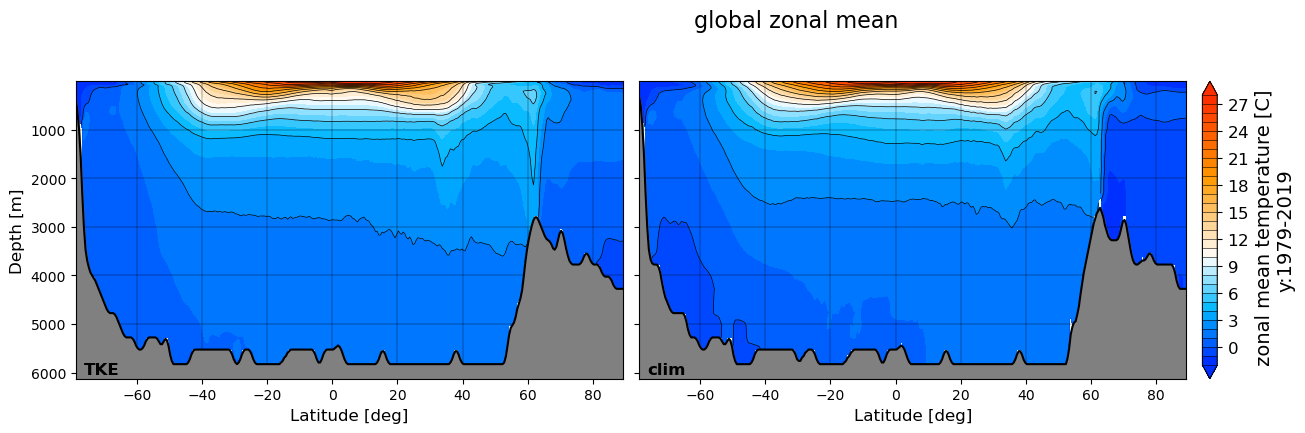

In [14]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
sname  = vname
slabel = list_zmtransects[0][0][sname].attrs['str_lsave']
strans = list_zmtransects[0][0][vname].attrs['transect_name'].replace(' ','_').lower()
if spath is not None: spath  = '{}/{}_{}_{}_{}.png'.format(spath, which_mode, sname, strans, slabel) 
ncolumn= np.min([ncolumn,len(list_zmtransects)])        
nrow   = np.ceil(len(list_zmtransects)/ncolumn).astype('int')
if save_fname is not None: spath = save_fname

fig, ax, cbar = tpv.plot_zmeantransects(list_zmtransects, cinfo=cinfo, figsize=[ncolumn*figfac[0], nrow*figfac[1]], n_rc=[nrow, ncolumn],
                                        do_rescale=do_rescale, do_reffig=do_reffig, ref_cinfo=ref_cinfo, ref_rescale=ref_rescale,
                                        pos_gap=[0.01, 0.01], pos_extend=[0.05, 0.05, 0.85,0.90], cbar_nl=12, do_ylog = do_ylog, 
                                        do_save=spath, save_dpi=which_dpi, do_contour=do_contour )